# IA Project - Face Recognition with Dynamic Triplet Loss

References: https://openaccess.thecvf.com/content_ICCV_2019/papers/Zhang_Learning_Local_Descriptors_With_a_CDF-Based_Dynamic_Soft_Margin_ICCV_2019_paper.pdf

Dataset: http://vis-www.cs.umass.edu/lfw/#download

In [1]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np
import collections
import PIL.Image
from torch.utils.data import DataLoader, Subset
import os
import random
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Pre-precessing data

In [2]:
drive.mount("/content/drive")
root_dir = "/content/drive/My Drive/IA_Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
'''
#path
data_path = "./LFW_DIR"
train_path = "./data/train_pairs.txt"
test_path = "./data/test_pairs.txt"
people_path = "./data/people.txt"
'''

'\n#path\ndata_path = "./LFW_DIR"\ntrain_path = "./data/train_pairs.txt"\ntest_path = "./data/test_pairs.txt"\npeople_path = "./data/people.txt"\n'

In [4]:
data_path = os.path.join(root_dir, "LFW_DIR")
people_path = os.path.join(root_dir, "data/people.txt")

In [5]:
img_size = 224
crop_size = 64
batch_size = 32

In [6]:
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

test_transform = T.Compose([
    T.Resize(img_size),  # make 250x250
    T.CenterCrop(crop_size),   # then take 150x150 center crop
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

train_transform = T.Compose([
    T.Resize(img_size),
    T.RandomCrop(crop_size),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [7]:
def readPeople(people_path):
  people_list = []
  with open(people_path, 'r') as file:
    for line in file.readlines():
      person = line.strip().split()
      people_list.append(person)
  return people_list

In [8]:
people_list= readPeople(people_path)
# people_list

In [9]:
# cambiare i nomi con le labels
def getLabeledImages(data_path, people_list):
  labeledImages = {}
  label = 0
  

  for person in people_list:
    if int(person[1]) > 1:    # se ho più di una immagine per persona
      for img_id in range(1, int(person[1])+1):
        path = os.path.join(data_path, person[0], person[0] + '_' + '%04d' % img_id + '.jpg')
        labeledImages[path] = label
      label += 1

  return labeledImages

In [10]:
labeledImages = getLabeledImages(data_path, people_list)
print(len(labeledImages.keys()))    # dizionario 'img_path: label'
print(len(set(labeledImages.values())))

9164
1680


In [11]:
# shuffle labeledImages
list_item = list(labeledImages.items())
#random.shuffle(list_item)
labeledImages_rand = dict(list_item)

# Dataset fraction
test_frac = 0.1
val_frac = 0.1

# data len
num_data = len(labeledImages_rand)
num_test = int(num_data*test_frac)
num_val = int(num_data*val_frac)

# split dict in train, test, val
num_data = num_data - num_test
labeled_test = dict(list(labeledImages_rand.items())[num_data:]) 
labeledImages_rand = dict(list(labeledImages_rand.items())[:num_data])

num_data = num_data - num_val
labeled_val = dict(list(labeledImages_rand.items())[num_data:]) 
labeled_train = dict(list(labeledImages_rand.items())[:num_data])

In [12]:
print(len(labeled_train), len(labeled_test), len(labeled_val))

7332 916 916


In [ ]:
'''
def getTriplet(index, labeledImages):
  images_path = list(labeledImages.keys())
  anchor_path = images_path[index]
  anchor_label = labeledImages[anchor_path]
  anchor_img = PIL.Image.open(anchor_path)

  positive_list = [item for item in images_path 
                   if labeledImages[item] == anchor_label and item != anchor_path]
  positive_path = random.choice(positive_list)

  negative_list = [item for item in images_path if item not in positive_list]
  negative_path = random.choice(negative_list)

  positive_img = PIL.Image.open(positive_path)
  negative_img = PIL.Image.open(negative_path)

  return anchor_img, positive_img, negative_img, anchor_label
  '''

In [13]:
class LFWDataset(torch.utils.data.Dataset):

  def __init__(self, labeledImages, train=True, transform=None):
    self.transform = transform
    self.labeledImages = labeledImages
    self.images_path = list(self.labeledImages.keys())
    self.train = train

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self, index):
    anchor_path = self.images_path[index]
    anchor_label = self.labeledImages[anchor_path]
    anchor_img = PIL.Image.open(anchor_path)

    if self.train:
      # get positive image path
      positive_list = [item for item in self.images_path 
                        if self.labeledImages[item] == anchor_label and item != anchor_path]
      positive_path = random.choice(positive_list)

      # get negative image path
      negative_list = [item for item in self.labeledImages.keys() 
                        if item not in positive_list]
      negative_path = random.choice(negative_list)

      # get images from paths
      positive_img = PIL.Image.open(positive_path)
      negative_img = PIL.Image.open(negative_path)

    # transform images
      if self.transform:
        anchor_img = self.transform(anchor_img)
        positive_img = self.transform(positive_img)
        negative_img = self.transform(negative_img)

      return anchor_img, positive_img, negative_img, anchor_label

    else:
      if self.transform:
        anchor_img = self.transform(anchor_img)
      return anchor_img, anchor_label

In [14]:
train_dataset = LFWDataset(labeled_train, train=True, transform=train_transform)
test_dataset = LFWDataset(labeled_test, train=False, transform=test_transform)
val_dataset = LFWDataset(labeled_val, train=False, transform=test_transform)

In [16]:
num_train = len(train_dataset)
num_test = len(test_dataset)
num_val = len(val_dataset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples: {num_test}")
print(f"Num. val samples: {num_val}")

Num. training samples: 7332
Num. test samples: 916
Num. val samples: 916


In [17]:
# Define loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, num_workers=4, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, num_workers=4, shuffle=False)

In [18]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

### Dynamic Triplet Loss implementation

In [19]:
def pairwise_dist(x, y = None):
  x_norm = (x**2).sum(1).view(-1, 1)
  if y is not None:
    y_norm = (y**2).sum(1).view(1, -1)
  else:
    y = x
    y_norm = x_norm.view(1, -1)

  dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(y, 0, 1))
  return dist

In [20]:
class TripletLoss(nn.Module):
  def __init__(self, margin = 0.2):
    super(TripletLoss, self).__init__()
    self.margin = margin

  def forward(self, anchor, positive = None, negative = None):
    margin = self.margin
    pos_dist = pairwise_dist(anchor, positive)
    # print(pos_dist, pos_dist.shape)
    neg_dist = pairwise_dist(anchor, negative)
    # print(neg_dist)
    loss = torch.relu(pos_dist - neg_dist + margin)
    return loss.mean()

### CNN Model

In [21]:
len(set(labeledImages.values()))

1680

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=2, stride=4),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            # nn.Dropout(0.3),

            nn.Conv2d(64, 224, kernel_size=5, padding=2, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(224),
            # nn.Dropout(0.3)
          
            nn.Conv2d(224, 224, kernel_size=3, padding=1, stride=1),
            nn.PReLU(),
            #nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(224),
            # nn.Dropout(0.3)

            nn.Conv2d(224, 512, kernel_size=3, padding=1, stride=1),
            nn.PReLU(),
            #nn.MaxPool2d(kernel_size=4, stride=2),
            nn.BatchNorm2d(512),
            # nn.Dropout(0.3)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(4608, 2304),
            nn.PReLU(),
            nn.Linear(2304, 32)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [23]:
'''
        self.fc_layers = nn.Sequential(
            nn.Linear(4608, 2304),
            nn.PReLU(),
            nn.Linear(2304, 32)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x
'''

'\n        self.fc_layers = nn.Sequential(\n            nn.Linear(4608, 2304),\n            nn.PReLU(),\n            nn.Linear(2304, 32)\n        )\n        \n    def forward(self, x):\n        x = self.conv_layers(x)\n        x = x.view(x.size(0), -1)\n        x = self.fc_layers(x)\n        return x\n'

In [24]:
'''
    # Forward
    def forward(self, x):
      return self.conv_layers(x)
    
# Create the model
model = CNN()
# Get input
test_x = train_dataset[0][0].unsqueeze(0)
# Try forward
out_size = model(test_x).size()
print(f"Out feature maps: {out_size} => out features: {out_size[1]*out_size[2]*out_size[3]}")
'''

'\n    # Forward\n    def forward(self, x):\n      return self.conv_layers(x)\n    \n# Create the model\nmodel = CNN()\n# Get input\ntest_x = train_dataset[0][0].unsqueeze(0)\n# Try forward\nout_size = model(test_x).size()\nprint(f"Out feature maps: {out_size} => out features: {out_size[1]*out_size[2]*out_size[3]}")\n'

### Training Loop


In [25]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [33]:
def train(epochs, device, lr = 0.001):

  model = CNN()
  model.to(dev)
  print(model)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  history_loss = {"train": [], "val": [], "test": []}
  history_accuracy = {"train": [], "val": [], "test": []}

  try:
 
    for epoch in range(epochs):
      sum_loss = {"train": 0, "val": 0, "test": 0}
      sum_accuracy = {"train": 0, "val": 0, "test": 0}
      for split in ["train", "val", "test"]:
        torch.cuda.empty_cache()
        if split == "train":
          for step,(anchor_img, positive_img, negative_img, anchor_label) in enumerate(loaders[split]):

            # Move to CUDA
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)
            anchor_label = anchor_label.to(device)

            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            anchor_out = model(anchor_img)
            positive_out = model(positive_img)
            negative_out = model(negative_img)

            loss = TripletLoss()(anchor_out, positive_out, negative_out)

            # Update loss
            sum_loss[split] += loss

            # Check parameter update
            loss.backward()
            optimizer.step()

            _,pred_labels = anchor_out.max(1)
            batch_accuracy = (pred_labels == anchor_label).sum().item()/anchor_img.size(0)
            sum_accuracy[split] += batch_accuracy
        


      # Compute epoch loss
      epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
      epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
      # Update history
      for split in ["train", "val", "test"]:
        history_loss[split].append(epoch_loss[split])
        history_accuracy[split].append(epoch_accuracy[split])
      
      # Print info
      print(f"Epoch {epoch+1}:",
            f"TrL={epoch_loss['train']:.4f},",
            f"TrA={epoch_accuracy['train']:.4f},",
            f"VL={epoch_loss['val']:.4f},",
            f"VA={epoch_accuracy['val']:.4f},",
            f"TeL={epoch_loss['test']:.4f},",
            f"TeA={epoch_accuracy['test']:.4f},")
  except KeyboardInterrupt:
      print("Interrupted")
  finally:
      # Plot loss
      plt.title("Loss")
      for split in ["train", "val", "test"]:
        plt.plot(history_loss[split], label=split)
      plt.legend()
      plt.show()
      # Plot accuracy
      plt.title("Accuracy")
      for split in ["train", "val", "test"]:
        plt.plot(history_accuracy[split], label=split)
      plt.legend()
      plt.show()

In [ ]:
else:
          for step,(anchor_img, anchor_label) in enumerate(loaders[split]):
            # Move to CUDA
            anchor_img = anchor_img.to(device)
            # Reset gradients
            optimizer.zero_grad()
            # Compute output
            anchor_out = model(anchor_img)

            loss = TripletLoss()(anchor_out)
            # print(f"{split} loss: {loss}")

            # Update loss
            sum_loss[split] += loss

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): PReLU(num_parameters=1)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 224, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): PReLU(num_parameters=1)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(224, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=1)
    (10): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(224, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): PReLU(num_parameters=1)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

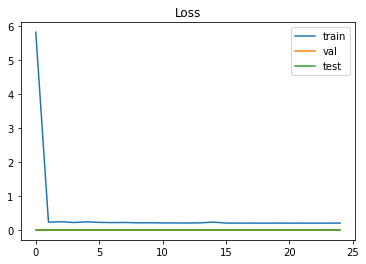

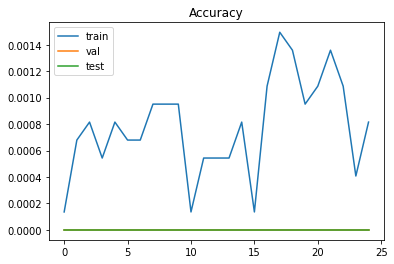

In [34]:
train(25, dev, 0.001)